In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats as st
from configparser import ConfigParser
import statsmodels.stats.multicomp as mc

In [191]:
# Classes and functions

def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # read connection parameters
        params = config()

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
		
        # create a cursor
        cur = conn.cursor()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    return cur

class StatsForGraphs():
    def __init__(self, df, var, value):
        self.df = df
        self.var = var
        self.value = value

    def compute_stats(self):
        mean = np.empty((0,1))
        std = np.empty((0,1))

        for item in self.df[self.var].unique():
            mean = np.append(mean, self.df[self.df[self.var] == item][self.value].mean())
            std = np.append(std, self.df[self.df[self.var] == item][self.value].std())
        return mean, std


class Unpaired_ttest():
    def __init__(self, df, var, category, value, col, h):
        self.df = df
        self.var = var
        self.categories = category
        self.value = value
        self.color = col
        self.h = h
    
    def perform_ttest(self):
        a = self.df.loc[self.df[self.var] == self.categories[0], self.value].to_numpy()
        b = self.df.loc[self.df[self.var] == self.categories[1], self.value].to_numpy()
        ttest = st.ttest_ind(a=a, b=b, equal_var=True)

        if ttest.pvalue >= 0.05:
            asterisk = 'ns'
        elif ttest.pvalue < 0.05 and ttest.pvalue >= 0.01:
            asterisk = '*'
        elif ttest.pvalue < 0.01 and ttest.pvalue >= 0.001:
            asterisk = '**'
        elif ttest.pvalue < 0.001 and ttest.pvalue >= 0.0001:
            asterisk = '***'
        else:
            asterisk = '****'
        return asterisk
    
    def graph_annotate(self, asterisk):
        categories = self.df[self.var].unique()
        idx1, idx2 = np.where(categories == self.categories[0])[0][0], np.where(categories == self.categories[1])[0][0]
        y1 = self.df[self.df[self.var] == self.categories[0]][self.value].max() + self.h
        y2 = self.df[self.df[self.var] == self.categories[1]][self.value].max() + self.h
        plt.plot([idx1, idx1, idx2, idx2], [y1, y1+(y2-y1)+self.h, y2+self.h, y2], lw=1.5, color=self.color)
        plt.text((idx1+idx2)*.5, np.max([y1,y2])+self.h, asterisk, ha='center', va='bottom', color=self.color)


class Multiple_ttest():
    def __init__(self, df, var, value, method, col, h):
        self.df = df
        self.var = var
        self.value = value
        self.method = method
        self.color = col
        self.h = h

    def perform_ttest(self):
        comp1 = mc.MultiComparison(self.df[self.value], self.df[self.var])
        tbl, a1, a2 = comp1.allpairtest(st.ttest_ind, alpha=0.05, method=self.method)
        pairs = a2[a2['pval_corr'] >= 0.0001][['group1','group2']]
        pvalues = a2[a2['pval_corr'] >= 0.0001]['pval_corr']

        asterisk = []
        for p in pvalues:
            if p >= 0.05:
                asterisk.append('ns')
            elif p < 0.05 and p >= 0.01:
                asterisk.append('*')
            elif p < 0.01 and p >= 0.001:
                asterisk.append('**')
            elif p < 0.001 and p >= 0.0001:
                asterisk.append('***')
            else:
                asterisk.append('****')
        return pairs, pvalues, asterisk
    
    def graph_annotate(self, pairs, asterisk):
        max = self.df.groupby(self.var).max()[self.value].reset_index(name='max')
        for idx, pair in enumerate(pairs):
            categories = self.df[self.var].unique()
            idx1, idx2 = np.where(categories == pair[0])[0][0], np.where(categories == pair[1])[0][0]
            y1 = max.loc[max[self.var]==pair[0], 'max'] + self.h
            y2 = max.loc[max[self.var]==pair[1], 'max'] + self.h
            max.loc[max[self.var]==pair[0], 'max'] = np.max([y1,y2]) + self.h
            max.loc[max[self.var]==pair[1], 'max'] = np.max([y1,y2]) + self.h
            # max.loc[max[self.var]==pair[1], 'max'] = max.loc[max[self.var]==pair[1], 'max'] + 4*self.h
            # y1 = self.df[self.df[self.var] == pair[0]][self.value].max() + self.h
            # y2 = self.df[self.df[self.var] == pair[1]][self.value].max() + self.h
            # plt.plot([idx1, idx1, idx2, idx2], [y1, y1+(y2-y1)+self.h, y2+self.h, y2], lw=1.5, color=self.color)
            plt.plot([idx1, idx1, idx2, idx2], [np.max([y1,y2]), np.max([y1,y2])+0.5*self.h, np.max([y1,y2])+0.5*self.h, np.max([y1,y2])], lw=1.5, color=self.color)
            plt.text((idx1+idx2)*.5, np.max([y1,y2])+0.5*self.h, asterisk[idx], ha='center', va='bottom', color=self.color)


class MathTextSciFormatter(ticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


Statistical analyses based on table "cell_attributes"

In [3]:
# Connect to database
cursor = connect()

# Load data from table V12_Platinum_158_dataset_All_stages
cursor.execute("SELECT * FROM cell_attributes")

# Obtain all rows of data table
cell_attributes = cursor.fetchall()

# Obtain column names
colnames = [desc[0] for desc in cursor.description]

# Create pandas DataFrame from list of tuples
df = pd.DataFrame(cell_attributes)

# Add column names to respective columns
df.columns = colnames

# Display first five rows of pandas DataFrame
df.head()

Connecting to the PostgreSQL database...


,cell_id,parent_label,genotype,sample_id,stage,cell_length_x,cell_length_y,cell_length_z,cell_wall_area,number_of_neighbors,outside_wall_area,outside_wall_area_ratio,volume
0,1835,7,ChiOX,1793,3-IV,6.00088,5.29523,6.09765,148.201,3,108.799,0.734131,142.288
1,1838,7,ChiOX,1793,3-IV,5.57317,4.97323,8.43972,147.736,7,105.308,0.712816,131.511
2,1842,7,ChiOX,1793,3-IV,7.01422,5.10685,9.65658,205.962,9,101.471,0.492667,228.485
3,1846,7,ChiOX,1793,3-IV,6.57697,4.84003,10.2757,221.655,13,114.535,0.516727,245.79
4,1847,7,ChiOX,1793,3-IV,5.87977,5.71539,6.19016,135.858,7,69.4824,0.511433,132.188


In [8]:
# Add parent and tissue label according to variable "parent_id"
df['parent_name']=df['parent_label'].apply(lambda x: 'oi2' if x==1 else ('oi1' if x==2 else ('ii2' if x==3 else ('ii1' if x==4 else ('nu' if x==5 else ('PCh' if x==6 else ('fu' if x==7 else ('es' if x==8 else ('pl' if x==9 else 'ACh')))))))))
df['tissue_label'] = df['parent_label'].apply(lambda x: 'oi' if x==1 or x==2 else ('ii' if x==3 or x==4 else ('ch' if x==6 or x==10 else ('nu' if x==5 else ('fu' if x==7 else ('es' if x==8 else 'pl'))))))
df.head()

,cell_id,parent_label,genotype,sample_id,stage,cell_length_x,cell_length_y,cell_length_z,cell_wall_area,number_of_neighbors,outside_wall_area,outside_wall_area_ratio,volume,parent_name,tissue_label
0,1835,7,ChiOX,1793,3-IV,6.00088,5.29523,6.09765,148.201,3,108.799,0.734131,142.288,fu,fu
1,1838,7,ChiOX,1793,3-IV,5.57317,4.97323,8.43972,147.736,7,105.308,0.712816,131.511,fu,fu
2,1842,7,ChiOX,1793,3-IV,7.01422,5.10685,9.65658,205.962,9,101.471,0.492667,228.485,fu,fu
3,1846,7,ChiOX,1793,3-IV,6.57697,4.84003,10.2757,221.655,13,114.535,0.516727,245.79,fu,fu
4,1847,7,ChiOX,1793,3-IV,5.87977,5.71539,6.19016,135.858,7,69.4824,0.511433,132.188,fu,fu


In [9]:
# Count unique values in variable "sample_id"
count_sample = df[['sample_id']].value_counts().reset_index(name='n')
print(count_sample)

   sample_id     n
0       1793  1803


In [10]:
# Group by variables "sample_id", "stage" and sum up the volume
volume_sample = df.groupby(['sample_id', 'stage'])['volume'].sum().reset_index()
print(volume_sample)

   sample_id stage          volume
0       1793  3-IV  549413.2776469


In [11]:
# Group by variables "sample_id", "stage" and sum up the volume
tissue_volume_sample = df.groupby(['stage', 'sample_id', 'tissue_label'])['volume'].sum().reset_index()
print(tissue_volume_sample)

  stage  sample_id tissue_label         volume
0  3-IV       1793           ch   89611.349193
1  3-IV       1793           es         5820.9
2  3-IV       1793           fu   84846.750602
3  3-IV       1793           ii     82750.5200
4  3-IV       1793           nu    13064.33455
5  3-IV       1793           oi  265555.296438
6  3-IV       1793           pl   7764.1268639


In [12]:
# Group by variables "sample_id", "stage" and count unique values in variable "parent"
count_parent_by_sample = df.groupby(['sample_id', 'stage'])['parent_label'].value_counts().sort_index(ascending=True).reset_index(name='n')
print(count_parent_by_sample)

    sample_id stage  parent_label    n
0        1793  3-IV             0   29
1        1793  3-IV             1  238
2        1793  3-IV             2  188
3        1793  3-IV             3  140
4        1793  3-IV             4  126
5        1793  3-IV             5   92
6        1793  3-IV             6  261
7        1793  3-IV             7  528
8        1793  3-IV             8    1
9        1793  3-IV            10  171
10       1793  3-IV            14   29


In [13]:
# Group by variables "stage" and count unique values in variable "sample_id"
count_sample_by_stage = df.groupby(['stage'])['sample_id'].value_counts().reset_index(name='n')
print(count_sample_by_stage)

  stage  sample_id     n
0  3-IV       1793  1803


Statistical analyses based on dataset "V12_Platinum_158_dataset_All_stages"

In [4]:
# Connect to database
cursor = connect()

# Load data from table V12_Platinum_158_dataset_All_stages
cursor.execute("SELECT * FROM v12_platinum_158_dataset")

# Obtain all rows of data table
v12_plat_158 = cursor.fetchall()

# Obtain column names
colnames = [desc[0] for desc in cursor.description]

Connecting to the PostgreSQL database...


In [5]:
# Create pandas DataFrame from list of tuples
df = pd.DataFrame(v12_plat_158)

# Add column names to respective columns
df.columns = colnames

# Display first five rows of pandas DataFrame
df.head()

,genotype,stage,pistil_id,ovule_id,cell_id,cell_type,cell_vol,cell_cycle,pd_pol_integ,dv_pol_ovule,distance_coordinate,max_pds_length,min_pds_length,ovule_metadata,cell_metadata,manual_proofread,unnamed_16
0,Col-0,1-II,290_7x,290_D,4163.0,L2,309.7,I,None,None,23.557,None,None,X290_D_dist,32.0,None,None
1,Col-0,1-II,290_7x,290_D,2154.0,L2,281.825,I,None,None,20.8733,None,None,X290_D_dist,32.0,None,None
2,Col-0,1-II,290_7x,290_D,63.0,L2,237.621,I,None,None,23.3274,None,None,X290_D_dist,32.0,None,None
3,Col-0,1-II,290_7x,290_D,3838.0,L2,232.475,I,None,None,26.291,None,None,X290_D_dist,32.0,None,None
4,Col-0,1-II,290_7x,290_D,1192.0,L1,212.399,I,None,None,22.6154,None,None,X290_D_dist,31.0,None,None


In [6]:
# Count number of cells per ovule per stage
# Group by variables "stage_id" and count unique values in "ovule_id"
count_cells_by_stage = df.groupby(['stage'])['ovule_id'].value_counts().reset_index(name='n')
print(count_cells_by_stage)

    stage ovule_id     n
0     1-I    786_B    48
1     1-I    783_A    46
2     1-I    784_B    45
3     1-I    786_D    45
4     1-I    785_C    41
..    ...      ...   ...
153  3-VI      752  1812
154  3-VI      756  1765
155  3-VI      754  1729
156  3-VI      755  1708
157  3-VI      559  1698

[158 rows x 3 columns]


In [17]:
# Unpaired t-test
a = count_cells_by_stage.loc[count_cells_by_stage['stage'] == '2-I', 'n'].to_numpy()
b = count_cells_by_stage.loc[count_cells_by_stage['stage'] == '2-II', 'n'].to_numpy()
ttest = st.ttest_ind(a=a, b=b, equal_var=True)

if ttest.pvalue >= 0.05:
    asterisk = 'ns'
elif ttest.pvalue < 0.05 and ttest.pvalue >= 0.01:
    asterisk = '*'
elif ttest.pvalue < 0.01 and ttest.pvalue >= 0.001:
    asterisk = '**'
elif ttest.pvalue < 0.001 and ttest.pvalue >= 0.0001:
    asterisk = '***'
else:
    asterisk = '****'

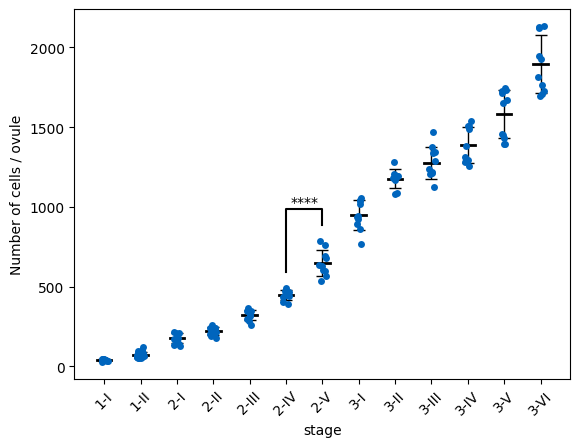

In [7]:
# Box plot of number of cells per ovule over stage

# Choose colors for boxplot
# PROPS = {
#     'boxprops':{'facecolor':'None', 'edgecolor':'black'},
#     'medianprops':{'color':'black'},
#     'whiskerprops':{'color':'black'}
# }

# Get statistics (mean, standard deviation)
stats = StatsForGraphs(count_cells_by_stage, 'stage', 'n')
means, stds = stats.compute_stats()

# Box plots
# sns.boxplot(data=count_cells_by_stage, x='stage', y='n', showfliers=False, **PROPS)
# sns.barplot(data=count_cells_by_stage, x='stage', y='n', ci='sd', color='lightblue')
plt.errorbar(count_cells_by_stage['stage'].unique(), means, yerr=stds, linestyle='None', lw=1.0, fmt='None', capsize=4.0, color='black')

for idx, stage in enumerate(count_cells_by_stage['stage'].unique()):
    plt.plot([idx-0.2,idx+0.2], [means[idx],means[idx]], color='black', lw=2.0)

# Scatter plots
sns.stripplot(data=count_cells_by_stage, x='stage', y='n', color='#0065bd', alpha=1.0)

# Statistical annotation
ttest = Unpaired_ttest(count_cells_by_stage, var='stage', category=['2-IV', '2-V'], value='n', col='black', h=100)
ast = ttest.perform_ttest()
ttest.graph_annotate(ast)

# Change label of y-axis
plt.ylabel('Number of cells / ovule')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.show()

In [170]:
max = count_cells_by_stage.groupby('stage').max()['n'].reset_index(name='max')
max.loc[max['stage']=='1-I', 'max'] = 50
max
# value = max.loc[max['stage']=='1-I', 'max']


,stage,max
0,1-I,50
1,1-II,120
2,2-I,215
3,2-II,259
4,2-III,366
5,2-IV,493
6,2-V,786
7,3-I,1053
8,3-II,1281
9,3-III,1470


In [178]:
# Multiple t-test with corrected p-values
comp1 = mc.MultiComparison(count_cells_by_stage['n'], count_cells_by_stage['stage'])
tbl, a1, a2 = comp1.allpairtest(st.ttest_ind, alpha=0.05, method='holm-sidak')

In [133]:
# a2[(a2['group1'] == '1-I') & (a2['group2'] == '2-I')]['pval_corr']

# Find all pairs with corrected p value >= 0.0001
pairs = a2[a2['pval_corr'] >= 0.0001][['group1','group2']]
pvalues = a2[a2['pval_corr'] >= 0.0001]['pval_corr']

asterisk = []
for p in pvalues:
    if p >= 0.05:
        asterisk.append('ns')
    elif p < 0.05 and p >= 0.01:
        asterisk.append('*')
    elif p < 0.01 and p >= 0.001:
        asterisk.append('**')
    elif p < 0.001 and p >= 0.0001:
        asterisk.append('***')
    else:
        asterisk.append('****')

print(pvalues, asterisk)

[0.0039 0.0245 0.0003 0.0254 0.0001 0.0112 0.0015] ['**', '*', '***', '*', '***', '*', '**']


In [181]:
# Find (corrected) p value for specific pairing
table = pd.DataFrame(a2)
table.loc[table['pval_corr'] >= 0.0001, ['group1','group2']]
# table.loc[(table['group1'] == '1-I') & (table['group2'] == '2-I'), 'pval_corr'].to_numpy()
# value = table[(table['group1']=='1-I') & (table['group2']=='1-II')]
# value = table[(table['group1']=='1-I') & (table['group2']=='1-II')]['pval_corr'].values[0]

,group1,group2
23,2-I,2-II
68,3-II,3-III
69,3-II,3-IV
72,3-III,3-IV
73,3-III,3-V
75,3-IV,3-V
77,3-V,3-VI


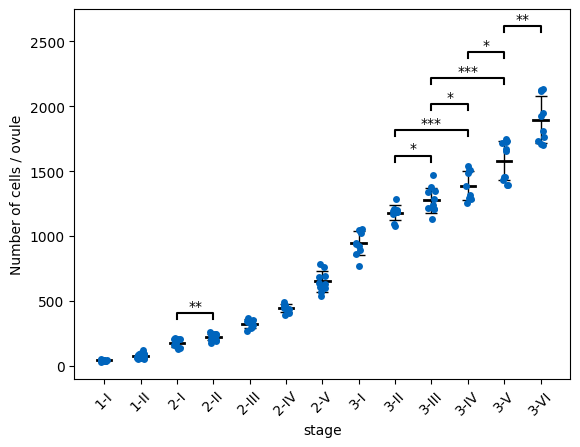

In [192]:
# Get statistics (mean, standard deviation)
stats = StatsForGraphs(count_cells_by_stage, 'stage', 'n')
means, stds = stats.compute_stats()

# Box plots
plt.errorbar(count_cells_by_stage['stage'].unique(), means, yerr=stds, linestyle='None', lw=1.0, fmt='None', capsize=4.0, color='black')

for idx, stage in enumerate(count_cells_by_stage['stage'].unique()):
    plt.plot([idx-0.2,idx+0.2], [means[idx],means[idx]], color='black', lw=2.0)

# Scatter plots
sns.stripplot(data=count_cells_by_stage, x='stage', y='n', color='#0065bd', alpha=1.0)

# Statistical annotation
ttest = Multiple_ttest(count_cells_by_stage, var='stage', value='n', method='holm-sidak', col='black', h=100)
pairs, pvalues, ast = ttest.perform_ttest()
ttest.graph_annotate(pairs, ast)

# Change label of y-axis
plt.ylabel('Number of cells / ovule')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.show()

In [19]:
# Compute total volume of ovule per stage
# Group by variables "stage", "ovule_id" and sum up the volume
ovule_volume_by_stage = df.groupby(['stage', 'ovule_id'])['cell_vol'].sum().reset_index()
ovule_volume_by_stage['cell_vol'] = ovule_volume_by_stage['cell_vol'].astype(float)
print(ovule_volume_by_stage)

    stage ovule_id     cell_vol
0     1-I    783_A    5273.1159
1     1-I    784_A    5118.4659
2     1-I    784_B    5755.6761
3     1-I    784_D    5650.7137
4     1-I    785_A    5501.2369
..    ...      ...          ...
153  3-VI      752  456429.0460
154  3-VI      753  493163.3260
155  3-VI      754  457321.2950
156  3-VI      755  388492.2140
157  3-VI      756  406446.5080

[158 rows x 3 columns]


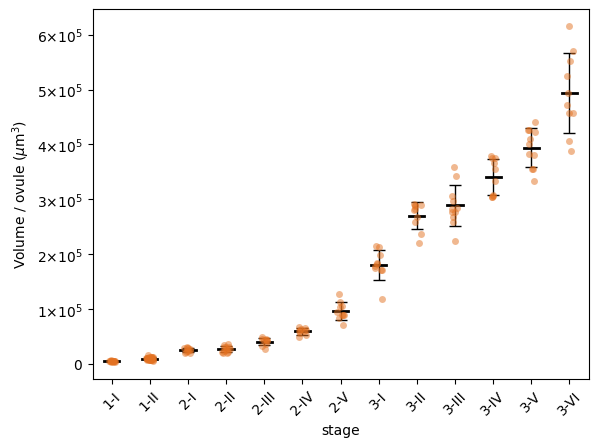

In [20]:
# Box plot of total volume of ovule over stage

# Convert variable "cell_vol" from type decimal to type float
ovule_volume_by_stage['cell_vol'] = ovule_volume_by_stage['cell_vol'].astype('float')

# Init plot
fig, ax = plt.subplots()

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'}
}

# Get statistics (mean, standard deviation)
stats = StatsForGraphs(ovule_volume_by_stage, 'stage', 'cell_vol')
means, stds = stats.compute_stats()

# Box plots
# sns.boxplot(data=ovule_volume_by_stage, x='stage', y='cell_vol', color='white', showfliers=False, whis=0.0, **PROPS)
# sns.barplot(data=ovule_volume_by_stage, x='stage', y='cell_vol', ci='sd', color='lightblue')
plt.errorbar(ovule_volume_by_stage['stage'].unique(), means, yerr=stds, linestyle='None', lw=1.0, fmt='None', capsize=4.0, color='black')

for idx, stage in enumerate(ovule_volume_by_stage['stage'].unique()):
    plt.plot([idx-0.2,idx+0.2], [means[idx],means[idx]], color='black', lw=2.0)

# Scatter plots
sns.stripplot(data=ovule_volume_by_stage, x='stage', y='cell_vol', color='#e37222', alpha=0.5)

# Change format of tick labels for readability
# ax.yaxis.set_major_formatter(ticker.EngFormatter())
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0e'))

# Format with 2 decimal places
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

# Change label of y-axis
plt.ylabel('Volume / ovule ($\mu$m$^3$)')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.show()

In [21]:
# Compute overall number of cells and number of mitotic cells per ovule per stage
# Group by variables "stage" and count unique values in variable "ovule_id"
count_mcells_by_stage = df[df['cell_cycle'] == 'M']
count_mcells_by_stage = count_mcells_by_stage.groupby(['stage'])['ovule_id'].value_counts().reset_index(name='n_mitotic')
print(count_mcells_by_stage)

    stage ovule_id  n_mitotic
0     1-I    784_B          1
1     1-I    784_D          1
2     1-I    786_B          1
3     1-I    787_B          1
4    1-II    601_B          2
..    ...      ...        ...
124  3-VI      756         12
125  3-VI      559         11
126  3-VI      751         10
127  3-VI      557          7
128  3-VI      752          6

[129 rows x 3 columns]


In [22]:
# Merge tables to display number of total cells and number of mitotic cells per ovule per stage

# Define variables by which to group
gr = ['ovule_id', 'stage']

# Merge DataFrames with a database-style join
count_by_stage = pd.merge(count_cells_by_stage, count_mcells_by_stage, left_on=gr, right_on=gr, how='outer')

# Replace NaN values in variable "n_mitotic" by zero values and convert back to type "integer"
count_by_stage['n_mitotic'] = count_by_stage['n_mitotic'].fillna(0).astype('int64')

# Calculate ratio between overall number of cells and number of mitotic cells
count_by_stage['ratio'] = count_by_stage['n_mitotic'] / count_by_stage['n']

# Print data
print(count_by_stage)

    stage ovule_id     n  n_mitotic     ratio
0     1-I    786_B    48          1  0.020833
1     1-I    783_A    46          0  0.000000
2     1-I    784_B    45          1  0.022222
3     1-I    786_D    45          0  0.000000
4     1-I    785_C    41          0  0.000000
..    ...      ...   ...        ...       ...
153  3-VI      752  1812          6  0.003311
154  3-VI      756  1765         12  0.006799
155  3-VI      754  1729         14  0.008097
156  3-VI      755  1708         12  0.007026
157  3-VI      559  1698         11  0.006478

[158 rows x 5 columns]


In [23]:
# Load data from table V12_Platinum_158_dataset_All_stages
# Filter by early stages (1-I until 2-IV)

cursor.execute("SELECT * FROM v12_platinum_158_dataset WHERE stage IN ('1-I','1-II','2-I','2-II','2-III','2-IV');")

# Obtain all rows of data table
v12_plat_158_early = cursor.fetchall()

# Obtain column names
colnames = [desc[0] for desc in cursor.description]

# Create pandas DataFrame from list of tuples
df = pd.DataFrame(v12_plat_158_early)

# Add column names to respective columns
df.columns = colnames

# Display first five rows of pandas DataFrame
df.head()

,genotype,stage,pistil_id,ovule_id,cell_id,cell_type,cell_vol,cell_cycle,pd_pol_integ,dv_pol_ovule,distance_coordinate,max_pds_length,min_pds_length,ovule_metadata,cell_metadata,manual_proofread,unnamed_16
0,Col-0,1-II,290_7x,290_D,4163.0,L2,309.7,I,None,None,23.557,None,None,X290_D_dist,32.0,None,None
1,Col-0,1-II,290_7x,290_D,2154.0,L2,281.825,I,None,None,20.8733,None,None,X290_D_dist,32.0,None,None
2,Col-0,1-II,290_7x,290_D,63.0,L2,237.621,I,None,None,23.3274,None,None,X290_D_dist,32.0,None,None
3,Col-0,1-II,290_7x,290_D,3838.0,L2,232.475,I,None,None,26.291,None,None,X290_D_dist,32.0,None,None
4,Col-0,1-II,290_7x,290_D,1192.0,L1,212.399,I,None,None,22.6154,None,None,X290_D_dist,31.0,None,None


In [24]:
# Count unique values in variable "stage"
by_stage = df[['stage']].value_counts().sort_index(ascending=True).reset_index(name='n')
print(by_stage)

   stage     n
0    1-I   554
1   1-II  2071
2    2-I  1946
3   2-II  2868
4  2-III  3241
5   2-IV  4471


In [25]:
# Load data from table V12_Platinum_158_dataset_All_stages
# Filter by later stages (2-II until 3-VI)

cursor.execute("SELECT * FROM v12_platinum_158_dataset WHERE stage IN ('2-II','2-III','2-IV','2-V','3-I','3-II','3-III','3-IV','3-V','3-VI');")

# Obtain all rows of data table
v12_plat_158_late = cursor.fetchall()

# Obtain column names
colnames = [desc[0] for desc in cursor.description]

# Create pandas DataFrame from list of tuples
df = pd.DataFrame(v12_plat_158_late)

# Add column names to respective columns
df.columns = colnames

# Display first five rows of pandas DataFrame
df.head()

,genotype,stage,pistil_id,ovule_id,cell_id,cell_type,cell_vol,cell_cycle,pd_pol_integ,dv_pol_ovule,distance_coordinate,max_pds_length,min_pds_length,ovule_metadata,cell_metadata,manual_proofread,unnamed_16
0,Col-0,2-II,769,769,383.0,L2,836.147,I,None,None,None,None,None,None,None,None,None
1,Col-0,2-II,769,769,775.0,L3,407.212,I,None,None,None,None,None,None,None,None,None
2,Col-0,2-II,769,769,787.0,L3,319.006,I,None,None,None,None,None,None,None,None,None
3,Col-0,2-II,769,769,255.0,L3,310.791,I,None,None,None,None,None,None,None,None,None
4,Col-0,2-II,769,769,261.0,L2,279.569,M,None,None,None,None,None,None,None,None,None


In [26]:
# Count unique values in variable "stage"
by_stage = df[['stage']].value_counts().sort_index(ascending=True).reset_index(name='n')
print(by_stage)

   stage      n
0   2-II   2868
1  2-III   3241
2   2-IV   4471
3    2-V   6487
4    3-I   9481
5   3-II  11775
6  3-III  14033
7   3-IV  13866
8    3-V  17375
9   3-VI  18968


In [27]:
# Load data from table V12_Platinum_158_dataset_All_stages
# Filter by specific stage and cell type/layer
# Adapt naming to chosen stage and cell type/layer

cursor.execute("SELECT * FROM v12_platinum_158_dataset WHERE stage='1-I' AND cell_type='L1'")

# Obtain all rows of data table
v12_plat_158_1I_L1 = cursor.fetchall()

# Obtain column names
colnames = [desc[0] for desc in cursor.description]

# Create pandas DataFrame from list of tuples
df = pd.DataFrame(v12_plat_158_1I_L1)

# Add column names to respective columns
df.columns = colnames

# Display first five rows of pandas DataFrame
df.head()

,genotype,stage,pistil_id,ovule_id,cell_id,cell_type,cell_vol,cell_cycle,pd_pol_integ,dv_pol_ovule,distance_coordinate,max_pds_length,min_pds_length,ovule_metadata,cell_metadata,manual_proofread,unnamed_16
0,Col-0,1-I,783_5x,783_A,2180.0,L1,205.062,I,None,None,16.0724,None,None,X783_A_41_dist,41.0,None,None
1,Col-0,1-I,783_5x,783_A,1260.0,L1,186.779,I,None,None,17.1828,None,None,X783_A_41_dist,41.0,None,None
2,Col-0,1-I,783_5x,783_A,1841.0,L1,179.353,I,None,None,8.51093,None,None,X783_A_41_dist,41.0,None,None
3,Col-0,1-I,783_5x,783_A,102.0,L1,158.205,I,None,None,14.7705,None,None,X783_A_41_dist,41.0,None,None
4,Col-0,1-I,783_5x,783_A,1181.0,L1,156.158,I,None,None,20.4346,None,None,X783_A_41_dist,41.0,None,None


In [28]:
# Count number of cells per ovule filtered by a specific stage and cell type/layer
count_per_ovule = df[['stage','ovule_id','cell_type']].value_counts().reset_index(name='n')
print(count_per_ovule)

   stage ovule_id cell_type   n
0    1-I    786_B        L1  32
1    1-I    783_A        L1  30
2    1-I    786_D        L1  30
3    1-I    784_B        L1  29
4    1-I    786_A        L1  28
5    1-I    785_C        L1  25
6    1-I    787_A        L1  25
7    1-I    787_B        L1  25
8    1-I    785_B        L1  24
9    1-I    784_A        L1  23
10   1-I    784_D        L1  23
11   1-I    785_A        L1  23
12   1-I    786_C        L1  21
13   1-I    786_E        L1  20
